# Sequence classification by RNN

* Creating the **data pipeline** with `tf.data`
* Preprocessing word sequences (variable input sequence length) using `tf.keras.preprocessing`
* Using `tf.nn.embedding_lookup` for getting vector of tokens (eg. word, character)
* Creating the model as **Class**
* Reference
  * https://github.com/golbin/TensorFlow-Tutorials/blob/master/10%20-%20RNN/02%20-%20Autocomplete.py
  * https://github.com/aisolab/TF_code_examples_for_Deep_learning/blob/master/Tutorial%20of%20implementing%20Sequence%20classification%20with%20RNN%20series.ipynb

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import tensorflow as tf

slim = tf.contrib.slim
rnn = tf.contrib.rnn

tf.logging.set_verbosity(tf.logging.INFO)

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

## Prepare example data

In [3]:
x_train_words = ['good', 'bad', 'amazing', 'so good', 'bull shit',
                 'awesome', 'how dare', 'very much', 'nice', 'god damn it',
                 'very very very happy', 'what the fuck']
y_train = np.array([0, 1, 0, 0, 1,
                    0, 1, 0, 0, 1,
                    0, 1], dtype=np.int32)

In [4]:
# positive sample
index = 0
print("word: {}\nlabel: {}".format(x_train_words[index], y_train[index]))

word: good
label: 0


In [5]:
# negative sample
index = 1
print("word: {}\nlabel: {}".format(x_train_words[index], y_train[index]))

word: bad
label: 1


## Tokenizer

In [6]:
tokenizer = Tokenizer(char_level=True)

In [7]:
%%time
tokenizer.fit_on_texts(x_train_words)

CPU times: user 513 µs, sys: 39 µs, total: 552 µs
Wall time: 594 µs


In [8]:
num_chars = len(tokenizer.word_index) + 1
print("number of characters: {}".format(num_chars))

number of characters: 25


In [9]:
tokenizer.word_index

{' ': 1,
 'e': 2,
 'o': 3,
 'a': 4,
 'd': 5,
 'h': 6,
 'r': 7,
 'y': 8,
 'g': 9,
 'm': 10,
 'i': 11,
 't': 12,
 'v': 13,
 'n': 14,
 's': 15,
 'u': 16,
 'w': 17,
 'c': 18,
 'b': 19,
 'l': 20,
 'p': 21,
 'z': 22,
 'f': 23,
 'k': 24}

In [10]:
x_train_tokens = tokenizer.texts_to_sequences(x_train_words)

In [11]:
index = 2
print("text: {}".format(x_train_words[index]))
print("token: {}".format(x_train_tokens[index]))

text: amazing
token: [4, 10, 4, 22, 11, 14, 9]


In [12]:
x_train_seq_length = np.array([len(tokens) for tokens in x_train_tokens], dtype=np.int32)
num_tokens = x_train_seq_length

In [13]:
max_tokens = np.max(num_tokens)
print(max_tokens)

20


### Create pad_seq data

In [14]:
#pad = 'pre'
pad = 'post'

In [15]:
x_train_pad = pad_sequences(sequences=x_train_tokens, maxlen=max_tokens,
                            padding=pad, truncating=pad)

In [16]:
index = 7
print("text: {}\n".format(x_train_words[index]))
print("token: {}\n".format(x_train_tokens[index]))
print("pad: {}".format(x_train_pad[index]))

text: very much

token: [13, 2, 7, 8, 1, 10, 16, 18, 6]

pad: [13  2  7  8  1 10 16 18  6  0  0  0  0  0  0  0  0  0  0  0]


### Tokenizer Inverse Map

In [17]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))
print(inverse_map)

{1: ' ', 2: 'e', 3: 'o', 4: 'a', 5: 'd', 6: 'h', 7: 'r', 8: 'y', 9: 'g', 10: 'm', 11: 'i', 12: 't', 13: 'v', 14: 'n', 15: 's', 16: 'u', 17: 'w', 18: 'c', 19: 'b', 20: 'l', 21: 'p', 22: 'z', 23: 'f', 24: 'k'}


In [18]:
def tokens_to_string(tokens):
  # Map from tokens back to words.
  words = [inverse_map[token] for token in tokens if token != 0]

  # Concatenate all words.
  text = "".join(words)

  return text

In [19]:
index = 10
print("original text:\n{}\n".format(x_train_words[index]))
print("tokens to string:\n{}".format(tokens_to_string(x_train_tokens[index])))

original text:
very very very happy

tokens to string:
very very very happy


## Create the Recurrent Neural Network

We are now ready to create the Recurrent Neural Network (RNN). We will use the TensorFlow API.

In [20]:
# Set the hyperparameter set
batch_size = 4
max_epochs = 10
#embedding_size = 8
num_units = 16 # the number of nodes in RNN hidden layer
num_classes = 2 # Two classes [True, False]
initializer_scale = 0.1
learning_rate = 1e-3

### Set up dataset with `tf.data`

#### create input pipeline with `tf.data.Dataset`

In [21]:
## create data pipeline with tf.data
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_pad, x_train_seq_length, y_train))
train_dataset = train_dataset.shuffle(buffer_size = 100)
train_dataset = train_dataset.repeat(max_epochs)
train_dataset = train_dataset.batch(batch_size = batch_size)
print(train_dataset)

<BatchDataset shapes: ((?, 20), (?,), (?,)), types: (tf.int32, tf.int32, tf.int32)>


#### Define Iterator

In [22]:
train_iterator = train_dataset.make_initializable_iterator()
seq_pad, seq_length, labels = train_iterator.get_next()

### Define CharRNN class

In [23]:
class CharRNN:
  def __init__(self, num_chars, max_length,
               seq_pad, seq_length, labels,
               num_units=num_units, num_classes=num_classes):
    self.num_chars = num_chars
    self.max_length = max_length
    self.seq_pad = seq_pad
    self.seq_length = seq_length
    self.labels = labels
    self.num_units = num_units
    self.num_classes = num_classes
    
  def build_embeddings(self):
    with tf.variable_scope('embedding_layer'):
      one_hot = tf.eye(self.num_chars, dtype=tf.float32)
      one_hot_matrix = tf.get_variable(name='one_hot_embedding',
                                       initializer=one_hot,
                                       trainable=False) # embedding matrix: No training
      self.embeddings = tf.nn.embedding_lookup(params=one_hot_matrix, ids=self.seq_pad)
      
  def build_layers(self):
    # RNN cell
    with tf.variable_scope('rnn_cell'):
      cell = rnn.BasicRNNCell(num_units=self.num_units)
      _, self.state = tf.nn.dynamic_rnn(cell=cell, inputs=self.embeddings,
                                        sequence_length=self.seq_length,
                                        dtype=tf.float32)
      
  def build_outputs(self):
    logits = slim.fully_connected(inputs=self.state,
                                  num_outputs=self.num_classes,
                                  activation_fn=None,
                                  scope='logits')
    return logits
  
  def bce_loss(self):
    one_hot_labels = tf.one_hot(self.labels, depth=self.num_classes)
    loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=one_hot_labels,
                                           logits=self.logits,
                                           scope='binary_cross_entropy')
    return loss
  
  def predict(self):
    with tf.variable_scope('prediction'):
      prediction = tf.argmax(input=self.logits, axis=-1, output_type=tf.int32)
      
      return prediction
  
  def build(self):
    self.global_step = tf.train.get_or_create_global_step()
    
    self.build_embeddings()
    self.build_layers()
    self.logits = self.build_outputs()
    
    self.loss = self.bce_loss()
    self.prediction = self.predict()
    
    print("complete model build.")

In [24]:
model = CharRNN(num_chars=num_chars,
                max_length=max_tokens,
                seq_pad=seq_pad,
                seq_length=seq_length,
                labels=labels,
                num_units=num_units,
                num_classes=num_classes)
model.build()

# show info for trainable variables
t_vars = tf.trainable_variables()
slim.model_analyzer.analyze_vars(t_vars, print_info=True)

complete model build.
---------
Variables: name (type shape) [size]
---------
rnn_cell/rnn/basic_rnn_cell/kernel:0 (float32_ref 41x16) [656, bytes: 2624]
rnn_cell/rnn/basic_rnn_cell/bias:0 (float32_ref 16) [16, bytes: 64]
logits/weights:0 (float32_ref 16x2) [32, bytes: 128]
logits/biases:0 (float32_ref 2) [2, bytes: 8]
Total size of variables: 706
Total bytes of variables: 2824


(706, 2824)

### Creat training op

In [25]:
# create training op
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(model.loss, global_step=model.global_step)

### `tf.Session()` and train

In [26]:
train_dir = './train/seq_classification/exp1'
if not tf.gfile.Exists(train_dir):
  print("mkdir: {}".format(train_dir))
  tf.gfile.MkDir(train_dir)
else:
  print("already exist!")
saver = tf.train.Saver(tf.global_variables(), max_to_keep=1000)

already exist!


In [27]:
sess = tf.Session(config=sess_config)
sess.run(tf.global_variables_initializer())
sess.run(train_iterator.initializer)

tf.logging.info('Start Session.')

# save loss values for plot
loss_history = []
pre_epochs = 0
while True:
  try:
    start_time = time.time()
    _, global_step, loss = sess.run([train_op,
                                     model.global_step,
                                     model.loss])
    
    epochs = global_step * batch_size / float(len(x_train_words))
    duration = time.time() - start_time

    print_steps = 1
    if global_step % print_steps == 0:
      #clear_output(wait=True)
      examples_per_sec = batch_size  / float(duration)
      print("Epochs: {:.3f} global_step: {} loss: {:.3f} ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                epochs, global_step, loss, examples_per_sec, duration))

      loss_history.append([epochs, loss])

    # save model checkpoint periodically
    save_epochs = 10
    if int(epochs) % save_epochs == 0  and  pre_epochs != int(epochs):
      tf.logging.info('Saving model with global step {} (= {} epochs) to disk.'.format(global_step, int(epochs)))
      saver.save(sess, train_dir + 'model.ckpt', global_step=global_step)
      pre_epochs = int(epochs)

  except tf.errors.OutOfRangeError:
    print("End of dataset")  # ==> "End of dataset"
    tf.logging.info('Saving model with global step {} (= {} epochs) to disk.'.format(global_step, int(epochs)))
    saver.save(sess, train_dir + 'model.ckpt', global_step=global_step)
    break

tf.logging.info('complete training...')

INFO:tensorflow:Start Session.
Epochs: 0.333 global_step: 1 loss: 0.685 (23.82 examples/sec; 0.168 sec/batch)
Epochs: 0.667 global_step: 2 loss: 0.618 (1158.09 examples/sec; 0.003 sec/batch)
Epochs: 1.000 global_step: 3 loss: 0.833 (928.92 examples/sec; 0.004 sec/batch)
Epochs: 1.333 global_step: 4 loss: 0.706 (1533.71 examples/sec; 0.003 sec/batch)
Epochs: 1.667 global_step: 5 loss: 0.621 (1594.19 examples/sec; 0.003 sec/batch)
Epochs: 2.000 global_step: 6 loss: 0.779 (861.70 examples/sec; 0.005 sec/batch)
Epochs: 2.333 global_step: 7 loss: 0.759 (936.33 examples/sec; 0.004 sec/batch)
Epochs: 2.667 global_step: 8 loss: 0.697 (1354.09 examples/sec; 0.003 sec/batch)
Epochs: 3.000 global_step: 9 loss: 0.623 (1600.73 examples/sec; 0.002 sec/batch)
Epochs: 3.333 global_step: 10 loss: 0.752 (890.04 examples/sec; 0.004 sec/batch)
Epochs: 3.667 global_step: 11 loss: 0.699 (1331.95 examples/sec; 0.003 sec/batch)
Epochs: 4.000 global_step: 12 loss: 0.600 (1197.94 examples/sec; 0.003 sec/batch)


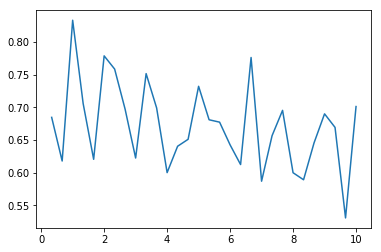

In [28]:
loss_history = np.array(loss_history)
plt.plot(loss_history[:,0], loss_history[:,1], label='train')

In [29]:
sess.run(train_iterator.initializer)
x_test_pad, y_pred = sess.run([model.seq_pad, model.prediction])

In [30]:
for x, y in zip(x_test_pad, y_pred):
  if y == 0:
    print("{} : good".format(tokens_to_string(x)))
  else:
    print("{} : bad".format(tokens_to_string(x)))

bad : bad
very much : good
awesome : good
god damn it : bad
